In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['seaborn-talk', 'seaborn-ticks'])

import cartopy.crs as ccrs

import numpy as np
import pandas as pd
import xarray as xr

import warnings; warnings.simplefilter('ignore')

# Clustering - Testing

As a first attempt at clustering, let's borrow the overall methdology from [Mahlstein and Knutti (2010)](http://dx.doi.org/10.1007/s00382-009-0654-0). In this work, they clustered based on the seasonal cycle at each grid point, using a $k$-means algorithm that maximized the within-cluster sum of deviations. 

They used both the seasonal cycle and its difference in the perturbed-climate scenario, along with grid cell altitude, latitude, longitude, and a continent label. They further restricted their data to land cells only.

~~I don't have altitude data immediately handy, but I can at least work with the continent labels.~~ I went ahead and found a nice 1-degree altitude dataset from [JISAO](http://research.jisao.washington.edu/data_sets/elevation/), and I used CDO to re-map it to the CESM grid, so we actually can add this in now!

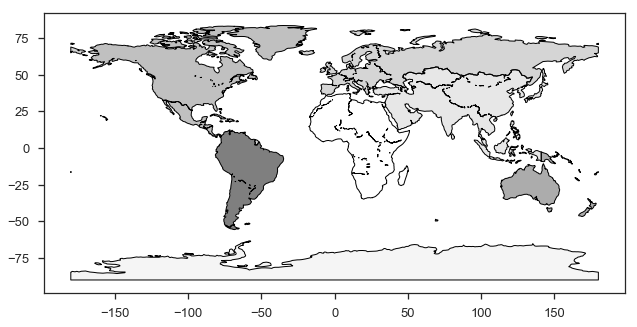

In [2]:
import shapely
import geopandas as gpd

# continents = gpd.read_file("../data/shapefiles/continent.shp")

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
continents = world[['continent', 'geometry']]
continents = continents.dissolve(by='continent')
continents = continents.reset_index()
continents.plot()

Now to read in the seasonal cycle data for hte FGM ensemble.

In [ ]:
import xarray as xr
from darpy import shift_lons

ds = xr.open_dataset("../data/processed/annual_cycle/fgm.cycle.nc")
ds = shift_lons(ds).roll(lon=len(ds.lon)//2 - 1)

data = ds.sel(ic=1, pol='REF')
present = data.sel(dec='1980-2010')
future = data.sel(dec='2085-2115')
change = future - present

## Label cells by continent

To label the cells by continent, we're going to perform a spatial join on our continent polygons, encoding 
each grid cell with its cell center. We first need to create a vector of all our grid cell centers as shapely `Point` objects.

In [4]:
from shapely.geometry import asPoint

llon, llat = np.meshgrid(data.lon.values, data.lat.values)
lon_lin, lat_lin = llon.ravel(), llat.ravel()
points = [asPoint(p) for p in np.column_stack([lon_lin, lat_lin])]

pts = gpd.GeoDataFrame({'lon': lon_lin, 'lat': lat_lin, 'geometry': gpd.GeoSeries(points)})
pts.head()

,geometry,lat,lon
0,POINT (-177.5 -90),-90.0,-177.5
1,POINT (-175 -90),-90.0,-175.0
2,POINT (-172.5 -90),-90.0,-172.5
3,POINT (-170 -90),-90.0,-170.0
4,POINT (-167.5 -90),-90.0,-167.5


Then, we simply use the spatial join features from geopandas, which will use shapely behind the scenes.

In [5]:
# Subset points if wanted
indices = np.random.randint(0, len(pts), 1000)
indices = np.unique(indices)

_pts = pts.iloc[indices]

joined = gpd.sjoin(pts, continents, how='inner', op='intersects')
joined.head()

,geometry,lat,lon,index_right,continent
0,POINT (-177.5 -90),-90.0,-177.5,1,Antarctica
1,POINT (-175 -90),-90.0,-175.0,1,Antarctica
2,POINT (-172.5 -90),-90.0,-172.5,1,Antarctica
3,POINT (-170 -90),-90.0,-170.0,1,Antarctica
4,POINT (-167.5 -90),-90.0,-167.5,1,Antarctica


As a proof-of-concept, merge our labels back into the original dataset so we can use them as a masking coordinate.

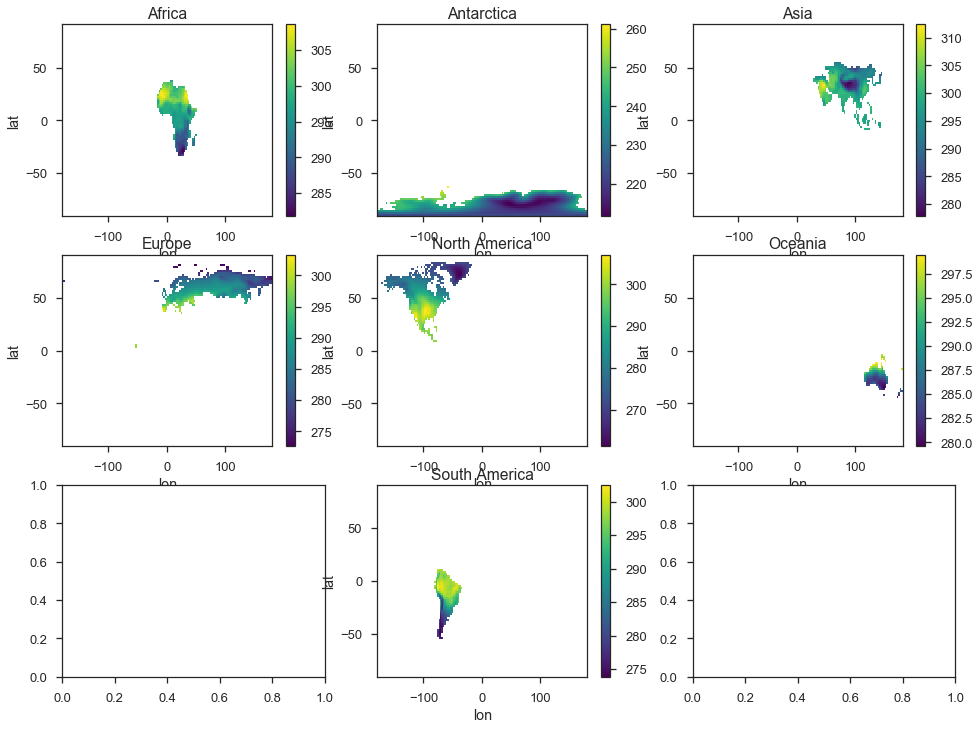

In [6]:
labels = (
    joined[['lat', 'lon', 'continent']]
    .assign(continent=lambda x: x.continent.astype('category'))
    .set_index(['lat', 'lon'])
    .sortlevel()
    .to_xarray()
)

x = (
    data
    .copy()
    .merge(labels)
    .set_coords('continent')
    .isel(dec=0, month=6)
)

cc = continents.continent
fig, axs = plt.subplots(3, 3, figsize=(16, 12))
axs = axs.ravel()
for continent, ax in zip(cc, axs):
    try:
        x['TREFHT'].where(x.continent == continent).plot.imshow('lon', 'lat', ax=ax)
    except:
        continue
    ax.set_title(continent)

## Land-sea mask

Must *NOT* shift lons to use this!

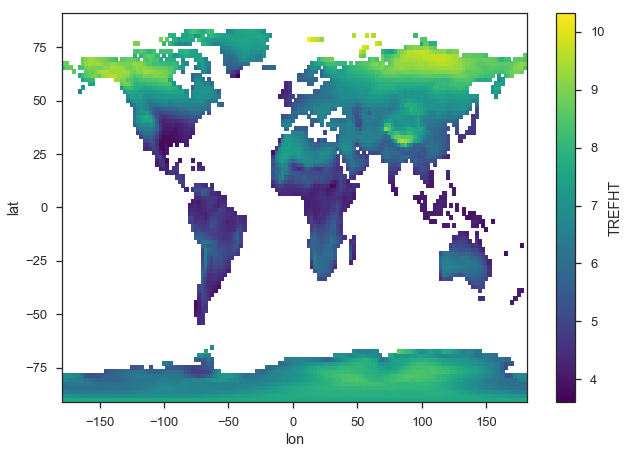

In [7]:
from darpy import landsea_mask

lsm = landsea_mask(change)
change.where(~lsm).mean('month')['TREFHT'].plot()

## Prep for clustering

Just to be pedantic, re-select the seasonal cycle data that we want to use.

In [8]:
data = (
    ds
    .sel(ic=1, pol='REF')
    .merge(labels)
    .set_coords('continent')
)
present = data.sel(dec='1980-2010')
future = data.sel(dec='2085-2115')
change = future - present

Now, merge into a tidy dataset, including our labels and the seasonal cycle for the present day and the climate change differences.

In [10]:
fld = 'TREFHT'

left = (
    present[fld]
    .to_dataframe()[[fld, ]]
    .unstack(0)[fld]
    .add_prefix("present_")
)
right = (
    change[fld]
    .to_dataframe()[[fld, ]]
    .unstack(0)[fld]
    .add_prefix("change_")
)
cont = change.isel(month=0).to_dataframe()['continent']
elev2d = (
    xr.open_dataset("../data/geo/elev.fgm-grid.nc")
    .squeeze()
    .rename({'data': 'elev'})
)
elev2d = shift_lons(elev2d).roll(lon=len(elev2d.lon)//2 - 1)
elev = elev2d.to_dataframe()[['elev', ]]

comps = [
    cont,
    elev,
    left,
    right
]

raw = pd.concat(comps, axis=1)
_to_preprocess = raw.reset_index().copy()

# Lat/Lon -> Radians
# _to_preprocess = _to_preprocess.assign(lat=np.deg2rad(_to_preprocess.lat),
#                                        lon=np.deg2rad(_to_preprocess.lon))

# Merge Europe/Asia
europe_or_asia = _to_preprocess.continent.isin(['Europe', 'Asia'])
_to_preprocess.continent[europe_or_asia] = 'Eurasia'
_to_preprocess.continent = _to_preprocess.continent.astype('category')

# Drop ocean cells and Antarctica cells
_to_preprocess = _to_preprocess[~_to_preprocess.continent.isin(['Antarctica', np.nan])]
# _to_preprocess = _to_preprocess[~_to_preprocess.continent.isin(['Antarctica', ])]
# _to_preprocess = _to_preprocess[_to_preprocess.elev > 0]

# Encode the category
_to_preprocess = _to_preprocess.assign(continent=lambda x: x.continent.cat.codes)

In [11]:
_to_preprocess.columns

Index(['lat', 'lon', 'continent', 'elev', 'present_1', 'present_2',
       'present_3', 'present_4', 'present_5', 'present_6', 'present_7',
       'present_8', 'present_9', 'present_10', 'present_11', 'present_12',
       'change_1', 'change_2', 'change_3', 'change_4', 'change_5', 'change_6',
       'change_7', 'change_8', 'change_9', 'change_10', 'change_11',
       'change_12'],
      dtype='object')

In [12]:
from sklearn_pandas import DataFrameMapper
import sklearn

# mapper = DataFrameMapper([
#     ('elev', sklearn.preprocessing.StandardScaler())
# ], default=None)
# mapper = DataFrameMapper([
#     ('lat', None),
#     ('lon', None),
#     ('continent', None),
# #     ('elev', sklearn.preprocessing.MinMaxScaler())
# ], None, # default=sklearn.preprocessing.MinMaxScaler()
# )
mapper = DataFrameMapper([
#     ('lat', None),
#     ('lon', None),
    (['continent',],  sklearn.preprocessing.OneHotEncoder()),
], sklearn.preprocessing.MinMaxScaler(), 
)

mapped = mapper.fit_transform(
    _to_preprocess.drop(
#         ['lon', 'lat'],
        [],
        axis=1)
)
# mapped = _to_preprocess.copy().values

Finally we can take our arrays.

In [13]:
XX = mapped.copy()
nobs, nfeatures = XX.shape
print(nobs, nfeatures)

3284 32


## K-Means Clustering

In [14]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=22, algorithm='full',
               n_init=50, max_iter=1000,verbose=0)
y_pred = model.fit_predict(XX)

In [15]:
temp = _to_preprocess[['lat', 'lon']].copy()
# temp = np.rad2deg(temp)

clusters = (
    temp.copy()[['lat', 'lon']]
    .assign(cluster=y_pred)
    .set_index(['lat', 'lon'])
    .sortlevel()
    .to_xarray()
)

clusters = change.merge(clusters)[['cluster', ]]

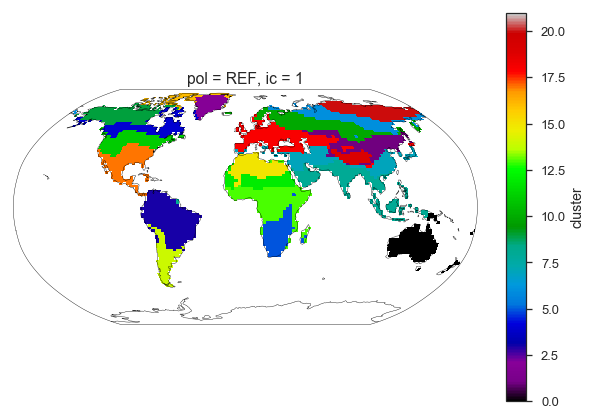

In [16]:
import cartopy.crs as ccrs
fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.Robinson())

clusters['cluster'].plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap='spectral')
ax.coastlines()

## Agglomerative Clustering

- [Ward hierearchical clustering example on an image](http://scikit-learn.org/stable/auto_examples/cluster/plot_face_ward_segmentation.html)
- [Scipy Hierarchical CLustering and Dendrogram Tutorial](https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/)

In [17]:
fld = 'TREFHT'

data = (
    ds
    .sel(ic=1, pol='REF')
    .merge(labels)
    .set_coords('continent')
)
present = data.sel(dec='1980-2010')
future = data.sel(dec='2085-2115')
change = future - present

## Compute the grid cell mask - only continent areas.
def _poor_isin(arr, vals, op='or'):
    if op not in ['and', 'or']:
        raise ValueError("Unknown op '{}'".format(op))
        
    mask = np.ones_like(arr) if op == 'and' else np.zeros_like(arr)
    for val in vals:
        if op == 'and':
            mask = mask & (arr == val)
        elif op == 'or':
            mask = mask | (arr == val)
    return mask
_x = change[fld].isel(month=0)
CCC = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']
mask = _x.where(_poor_isin(_x.continent, CCC))
mask = ~np.isnan(mask)

## Coerce to DataFrames
_pres = (
    present[fld]
    .to_dataframe()[[fld, ]]
    .unstack(0)[fld]
    .add_prefix("present_")
)
_chng = (
    change[fld]
    .to_dataframe()[[fld, ]]
    .unstack(0)[fld]
    .add_prefix("change_")
)
cont = change.isel(month=0).to_dataframe()['continent']
elev2d = (
    xr.open_dataset("../data/geo/elev.fgm-grid.nc")
    .squeeze()
    .rename({'data': 'elev'})
)
elev2d = shift_lons(elev2d).roll(lon=len(elev2d.lon)//2 - 1)
elev = elev2d.to_dataframe()[['elev', ]]

comps = [
    cont,
    elev,
    _pres,
    _chng
]

raw = pd.concat(comps, axis=1)
_to_preprocess = raw.reset_index().copy()

# Lat/Lon -> Radians
# _to_preprocess = _to_preprocess.assign(lat=np.deg2rad(_to_preprocess.lat),
#                                        lon=np.deg2rad(_to_preprocess.lon))

# Merge Europe/Asia
europe_or_asia = _to_preprocess.continent.isin(['Europe', 'Asia'])
_to_preprocess.continent[europe_or_asia] = 'Eurasia'
_to_preprocess.continent = _to_preprocess.continent.astype('category')

# Drop ocean cells and Antarctica cells
_to_preprocess = _to_preprocess[_to_preprocess.continent.isin(CCC + ['Eurasia', ])]
# _to_preprocess = _to_preprocess[_to_preprocess.elev > 0]

# Encode the category
_to_preprocess = _to_preprocess.assign(continent=lambda x: x.continent.cat.codes)

In [18]:
from sklearn_pandas import DataFrameMapper
import sklearn

# mapper = DataFrameMapper([
#     ('lat', None),
#     ('lon', None),
#     ('continent', None),
# #     ('elev', sklearn.preprocessing.MinMaxScaler())
# ], None, # default=sklearn.preprocessing.MinMaxScaler()
# )
mapper = DataFrameMapper([
    # ('lat', None),
    # ('lon', None),
    (['continent',], sklearn.preprocessing.OneHotEncoder())
], default=sklearn.preprocessing.MinMaxScaler()
)

XX = mapper.fit_transform(
    _to_preprocess.drop(
        ['lat', 'lon', ],
#         [],
        axis=1)
)
print(XX.shape)

(3284, 30)


In [19]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction import grid_to_graph
from sklearn.neighbors import DistanceMetric, kneighbors_graph

connectivity = grid_to_graph(*mask.shape, mask=mask.values)
# connectivity = kneighbors_graph(XX[:, :2], n_neighbors=2, include_self=False)
n_clusters = 20
hier = AgglomerativeClustering(n_clusters=n_clusters, 
                               linkage='ward', 
                               # linkage='average',
                               # affinity='cosine',
                               connectivity=connectivity,
                               compute_full_tree=True)
hier.fit(XX)
y_pred = hier.labels_

In [20]:
temp = _to_preprocess[['lat', 'lon']].copy()
# temp = np.rad2deg(temp)

clusters = (
    temp.copy()[['lat', 'lon']]
    .assign(cluster=y_pred)
    .set_index(['lat', 'lon'])
    .sortlevel()
    .to_xarray()
)

clusters = change.merge(clusters)[['cluster', ]]
del clusters['ic']
del clusters['pol']

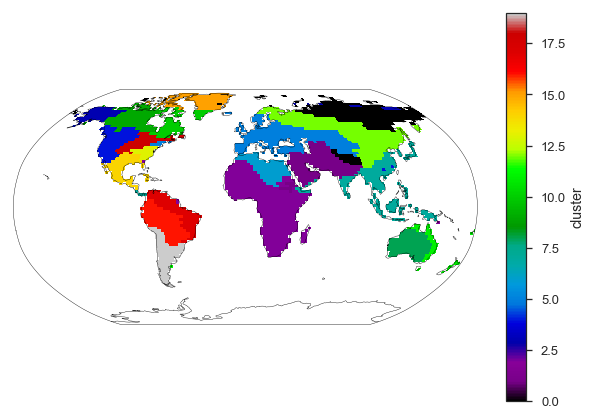

In [21]:
import cartopy.crs as ccrs

fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.Robinson())

clusters['cluster'].plot.imshow(ax=ax, transform=ccrs.PlateCarree(), 
                                cmap='spectral')
ax.coastlines()

(16.0, 20.0)


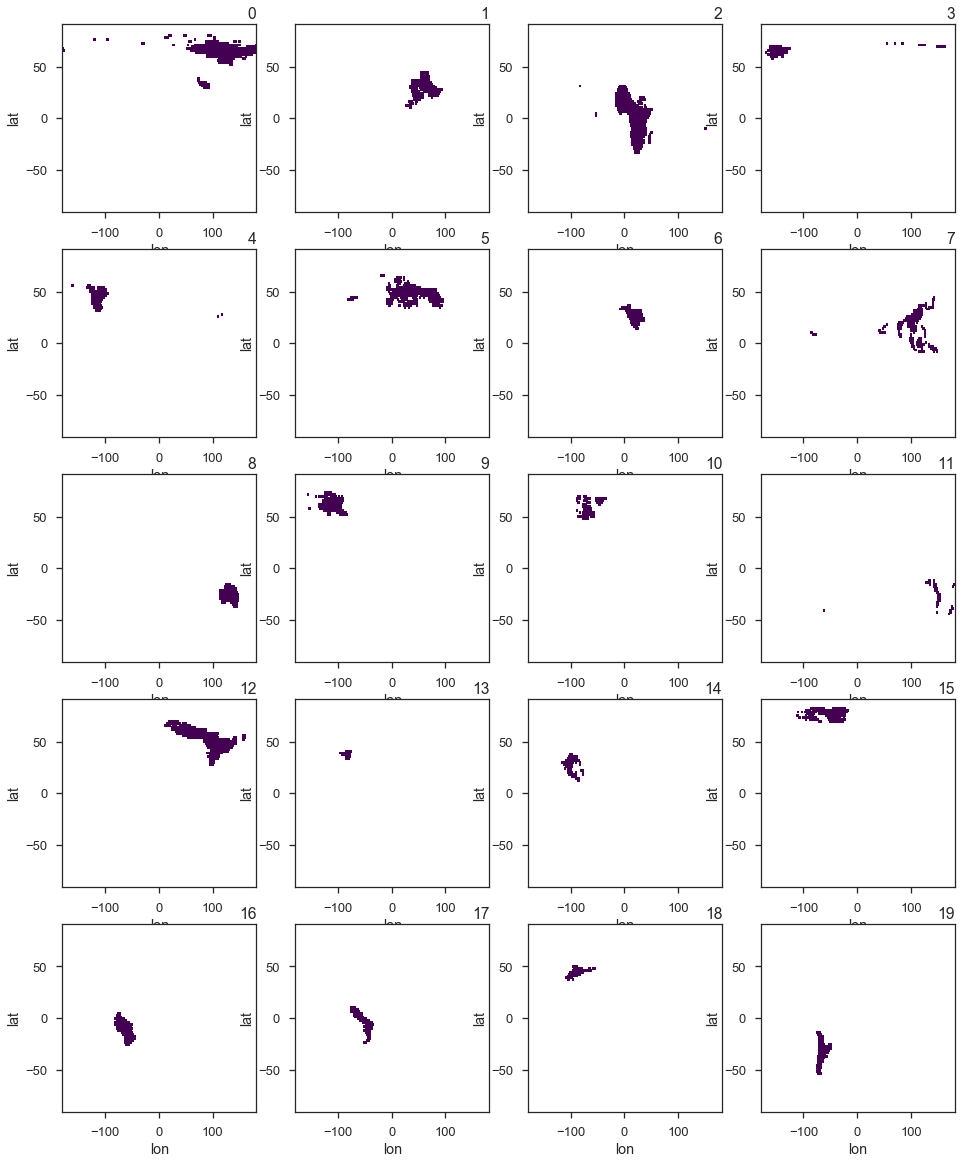

In [22]:
from darpy.plot import get_figsize

nrows, ncols = 5, n_clusters // 5
size, aspect = 4., 1.
figsize = get_figsize(nrows, ncols,  size, aspect)
print(figsize)
fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
for cluster, ax in zip(range(n_clusters), axs.ravel()):
    _c = clusters['cluster'].where(clusters.cluster == cluster)
    _c.plot.pcolormesh(ax=ax, infer_intervals=True, add_colorbar=False)
    ax.set_title("{}".format(cluster), loc='right')

## Joint Land/Ocean

In [24]:
from sklearn.feature_extraction import grid_to_graph

fld = 'TREFHT'

data = (
    ds
    .sel(ic=1, pol='REF')
    .merge(labels)
    .set_coords('continent')
    # .sel(lat=slice(-70, 70))
)
present = data.sel(dec='1980-2010')
future = data.sel(dec='2035-2065')
change = future - present

## Compute the grid cell mask - only continent areas.
_x = change[fld].isel(month=0)
CCC = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']

_mask = _x.where(_poor_isin(_x.continent, CCC))
mask_lnd= ~np.isnan(_mask)
mask_ocn = ~mask_lnd

## Coerce to DataFrames
_pres = (
    present[fld]
    .to_dataframe()[[fld, ]]
    .unstack(0)[fld]
    .add_prefix("present_")
)
_chng = (
    change[fld]
    .to_dataframe()[[fld, ]]
    .unstack(0)[fld]
    .add_prefix("change_")
)
cont = change.isel(month=0).to_dataframe()['continent']
elev2d = (
    xr.open_dataset("../data/geo/elev.fgm-grid.nc")
    .squeeze()
    .rename({'data': 'elev'})
)
elev2d = shift_lons(elev2d).roll(lon=len(elev2d.lon)//2 - 1)
elev = elev2d.to_dataframe()[['elev', ]]

comps = [
    cont,
    elev,
    _pres,
    _chng
]

raw = pd.concat(comps, join='inner', axis=1)
_to_preprocess = raw.reset_index().copy()

# Merge Europe/Asia
europe_or_asia = _to_preprocess.continent.isin(['Europe', 'Asia'])
_to_preprocess.continent[europe_or_asia] = 'Eurasia'
_to_preprocess.continent = _to_preprocess.continent.astype('category')

# Encode the continents
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(_to_preprocess.continent.cat.codes)

# Drop ocean cells and Antarctica cells
_to_preprocess_lnd = _to_preprocess[_to_preprocess.continent.isin(CCC + ['Eurasia', ])]
_to_preprocess_ocn = _to_preprocess[~_to_preprocess.continent.isin(CCC + ['Eurasia', ])]
_to_preprocess = _to_preprocess.assign(continent=lambda x: x.continent.cat.codes)
_to_preprocess_lnd = _to_preprocess_lnd.assign(continent=lambda x: x.continent.cat.codes)
_to_preprocess_ocn = _to_preprocess_ocn.assign(continent=lambda x: x.continent.cat.codes)

# Finalize encoding of continents
_to_preprocess.continent.values[:] = le.transform(_to_preprocess.continent.values)
_to_preprocess_lnd.continent.values[:] = le.transform(_to_preprocess_lnd.continent.values)
_to_preprocess_ocn.continent.values[:] = le.transform(_to_preprocess_ocn.continent.values)

# Compute connectivity matrices
conn_ocn = grid_to_graph(*mask_ocn.shape)#, mask=mask_ocn.values)
conn_lnd = grid_to_graph(*mask_lnd.shape)#, mask=mask_lnd.values)
print(conn_ocn.shape, conn_lnd.shape)
conn = conn_ocn + conn_lnd

(13824, 13824) (13824, 13824)


In [25]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder
import sklearn

mapper = DataFrameMapper([
    (['present_{:d}'.format(i+1) for i in range(12)],
     MinMaxScaler()),
    (['change_{:d}'.format(i+1) for i in range(12)],
     MinMaxScaler()),
#     (['continent',], OneHotEncoder()),
    ('elev', MinMaxScaler())
], None # MinMaxScaler()
)

XX = mapper.fit_transform(
    _to_preprocess.drop(
        ['lat', 'lon', 'continent'],
        axis=1)
)
print(XX.shape)

(13824, 25)


/Users/daniel/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/daniel/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [26]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction import grid_to_graph
from sklearn.neighbors import DistanceMetric, kneighbors_graph

n_clusters = 40
hier = AgglomerativeClustering(n_clusters=n_clusters, 
                               linkage='ward', 
                               connectivity=conn,
                               compute_full_tree=True)
hier.fit(XX)
y_pred = hier.labels_

In [27]:
temp = _to_preprocess[['lat', 'lon']].copy()
# temp = np.rad2deg(temp)

clusters = (
    temp.copy()[['lat', 'lon']]
    .assign(cluster=y_pred)
    .set_index(['lat', 'lon'])
    .sortlevel()
    .to_xarray()
)

clusters = change.merge(clusters)[['cluster', ]]
del clusters['ic']
del clusters['pol']

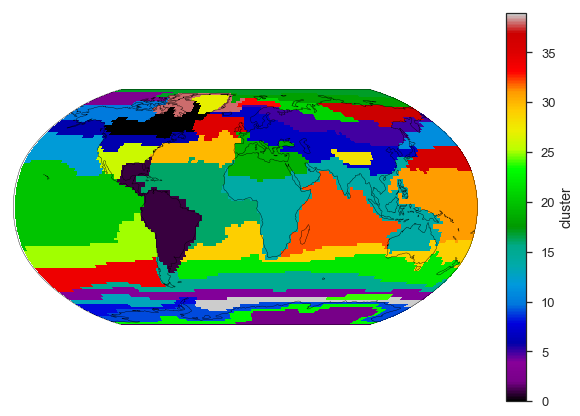

In [28]:
import cartopy.crs as ccrs

fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.Robinson())

clusters['cluster'].plot.imshow(ax=ax, transform=ccrs.PlateCarree(), 
                                cmap='spectral')
ax.coastlines()

# plt.savefig("../figs/hs2012/clusters/fgm.ward.lnd_ocn-sample.png", dpi=120, 
#             transparent=True, bbox_inches='tight')

## Adjaceny Testing

[3 4 4 3 4 5 5 4 4 5 5 4 4 5 5 4 3 4 4 3]
[4 5 5 4 4 5 5 4 4 5 5 4 4 5 5 4 4 5 5 4]


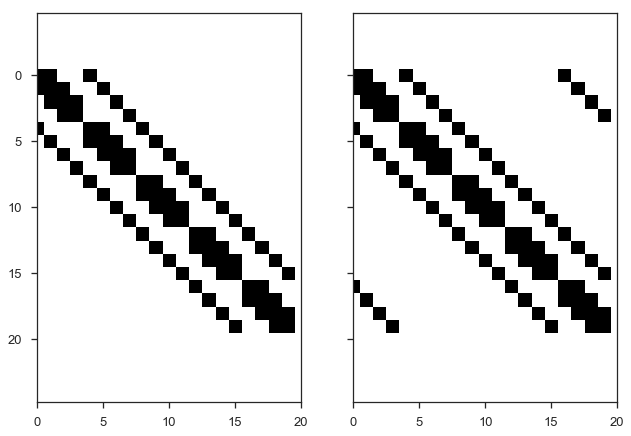

In [29]:
from sklearn.feature_extraction import grid_to_graph
from air_quality.models.hawkins_sutton2012 import periodic_x_connectivity_matrix

fig, (axl, axr) = plt.subplots(1, 2, sharex=True, sharey=True, 
                               subplot_kw=dict(aspect='equal'))
n_x, n_y = [4, 5]
n_x, n_y = [n_y, n_x]

c1 = grid_to_graph(n_x, n_y).toarray()
axl.imshow(c1)

c2 = periodic_x_connectivity_matrix(n_x, n_y)
axr.imshow(c2)

axr.set_xlim(0, n_x*n_y)
axr.set_ylim(n_x*n_y, 0)

print(np.sum(c1, axis=0))
print(np.sum(c2, axis=0))

In [30]:
cc = 5

for i in range(n_x*n_y):
    if i == cc:
        print("|", end=' ')
    print("{:02d}".format(i), end=' ')
    if i == cc:
        print("|", end=' ')
print("")
for i, x in enumerate(c1[cc]):  
    if i == cc:
        print("|", end=' ')  
    print("{:2d}".format(x), end=' ')
    if i == cc:
        print("|", end=' ')
print("")
for i, x in enumerate(c2[cc]):
    if i == cc:
        print("|", end=' ')
    print("{:2d}".format(x), end=' ')
    if i == cc:
        print("|", end=' ')

00 01 02 03 04 | 05 | 06 07 08 09 10 11 12 13 14 15 16 17 18 19 
 0  1  0  0  1 |  1 |  1  0  0  1  0  0  0  0  0  0  0  0  0  0 
 0  1  0  0  1 |  1 |  1  0  0  1  0  0  0  0  0  0  0  0  0  0 

## Agglomerative w/ Periodic Adjacency

In [136]:
from sklearn.feature_extraction import grid_to_graph

# fld = 'TREFHT'
# scale = 1.
fld = 'O3_SRF'
scale = 1e9

# Get land/sea continent mask
from darpy import landsea_mask
lsm = (
    landsea_mask(ds)
    .transpose('lat', 'lon')
    .astype('int')
    .sel(lat=slice(-50, 70))
)
_landsea = lsm.to_dataframe('landsea')

data = (
    ds
    .sel(ic=1, pol='REF')
    .merge(labels)
    .set_coords('continent')
    .sel(lat=slice(-50, 70))
)
present = data.sel(dec='1980-2010')
future = data.sel(dec='2035-2065')
change = future - present

## Compute the grid cell mask - only continent areas.
_x = change[fld].isel(month=0)
CCC = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']

_mask = _x.where(_poor_isin(_x.continent, CCC))
mask_lnd= ~np.isnan(_mask)
mask_ocn = ~mask_lnd

## Coerce to DataFrames
_pres = (
    (present[fld]*scale)
    .to_dataframe()[[fld, ]]
    .unstack(0)[fld]
    .add_prefix("present_")
)
_chng = (
    (change[fld]*scale)
    .to_dataframe()[[fld, ]]
    .unstack(0)[fld]
    .add_prefix("change_")
)
elev2d = (
    xr.open_dataset("../data/geo/elev.fgm-grid.nc")
    .squeeze()
    .rename({'data': 'elev'})
)
elev2d = shift_lons(elev2d).roll(lon=len(elev2d.lon)//2 - 1)
# Map elevations < 0 (ocean) to 0
elev2d = elev2d.elev.where(elev2d.elev > 0).fillna(0.)
elev = elev2d.to_dataframe()[['elev', ]]

comps = [
    elev,
    _landsea,
    _pres,
    _chng
]

raw = pd.concat(comps, join='inner', axis=1)
_to_preprocess = raw.reset_index().copy()


# Reference "back to xarray" function
ref = _to_preprocess.copy().reset_index()[['lon', 'lat']].copy()
def back_to_xarray(y, name='data'):
    return (
        ref
        .set_index(['lat', 'lon'])
        .assign(**{name: y})
        .sortlevel()
        .to_xarray()
    )   


# Final df
_clustering_df = _to_preprocess.drop(['lon', 'lat'], axis=1)

Map pre-processing routines

In [143]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

mapper = DataFrameMapper([
    #(['landsea', ], OneHotEncoder()),
    (['elev', ], MinMaxScaler()),
    (['present_{:d}'.format(i+1) for i in range(12)], MinMaxScaler()),
    (['change_{:d}'.format(i+1) for i in range(12)], MinMaxScaler()),
#     (['present_r_{:d}'.format(i+1) for i in range(12)], MinMaxScaler())
],
# default=MinMaxScaler()
)

X = mapper.fit_transform(_clustering_df)

Get the adjacency matrix with the periodic-longitude boundary conditions

In [144]:
from air_quality.models.hawkins_sutton2012 import periodic_x_connectivity_matrix

conn_periodic_x = periodic_x_connectivity_matrix(*lsm.shape[::-1], order='F')

Test clustering application

In [145]:
from air_quality.util import shift_roll
from sklearn.cluster import AgglomerativeClustering

clusterer = AgglomerativeClustering(n_clusters=30, linkage='ward', 
                                    connectivity=conn_periodic_x,
                                    compute_full_tree=True)
pred = clusterer.fit_predict(X)
pred_ds = back_to_xarray(pred, 'cluster')

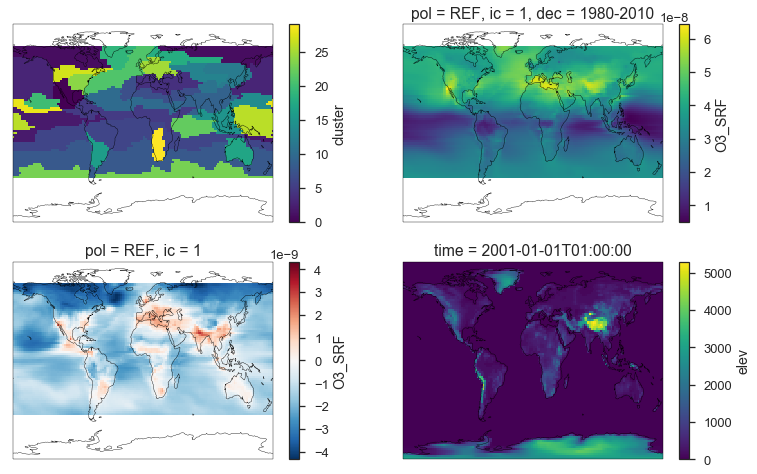

In [146]:
from darpy.plot import get_figsize

nrows, ncols = 2, 2
size, aspect = 4., 1.6
figsize = get_figsize(nrows, ncols, size, aspect)
fig, axs = plt.subplots(nrows, ncols, figsize=figsize,
                        subplot_kw=dict(projection=ccrs.PlateCarree(),
                                        aspect='auto'))
axs = axs.ravel()

plot_kws = dict(transform=ccrs.PlateCarree(), infer_intervals=True)
pred_ds.cluster.plot.pcolormesh(ax=axs[0], **plot_kws)
present[fld].mean('month').plot.pcolormesh(ax=axs[1], **plot_kws)
change[fld].mean('month').plot.pcolormesh(ax=axs[2], **plot_kws)
elev2d.plot.pcolormesh(ax=axs[3], **plot_kws)

for ax in axs:
    ax.set_global()
    ax.coastlines()

# Clustering -  Stats

Given a dataset with the same lat/lon grid as the data we have and a variable `cluster` which indicates which cells belong to which clusters, we can perform some statistics on those clusters.

In [32]:
from air_quality.util import fgm_unstack_years, shift_roll

sample_data = xr.open_dataset("../data/processed/seasonal_timeseries/fgm.TREFHT.JJA.nc")
data = (
    sample_data[['TREFHT', ]]
    .pipe(fgm_unstack_years)
    .sel(pol='REF')
    .pipe(lambda x: (x.sel(time=slice('2035', '2065')).mean('time') - 
                     x.sel(time=slice('1980', '2010')).mean('time')))
    .pipe(shift_roll)
    .assign(cluster=clusters['cluster'])
    .set_coords(['cluster'])
)

df = data.to_dataframe().reset_index().dropna(subset=['cluster', ])


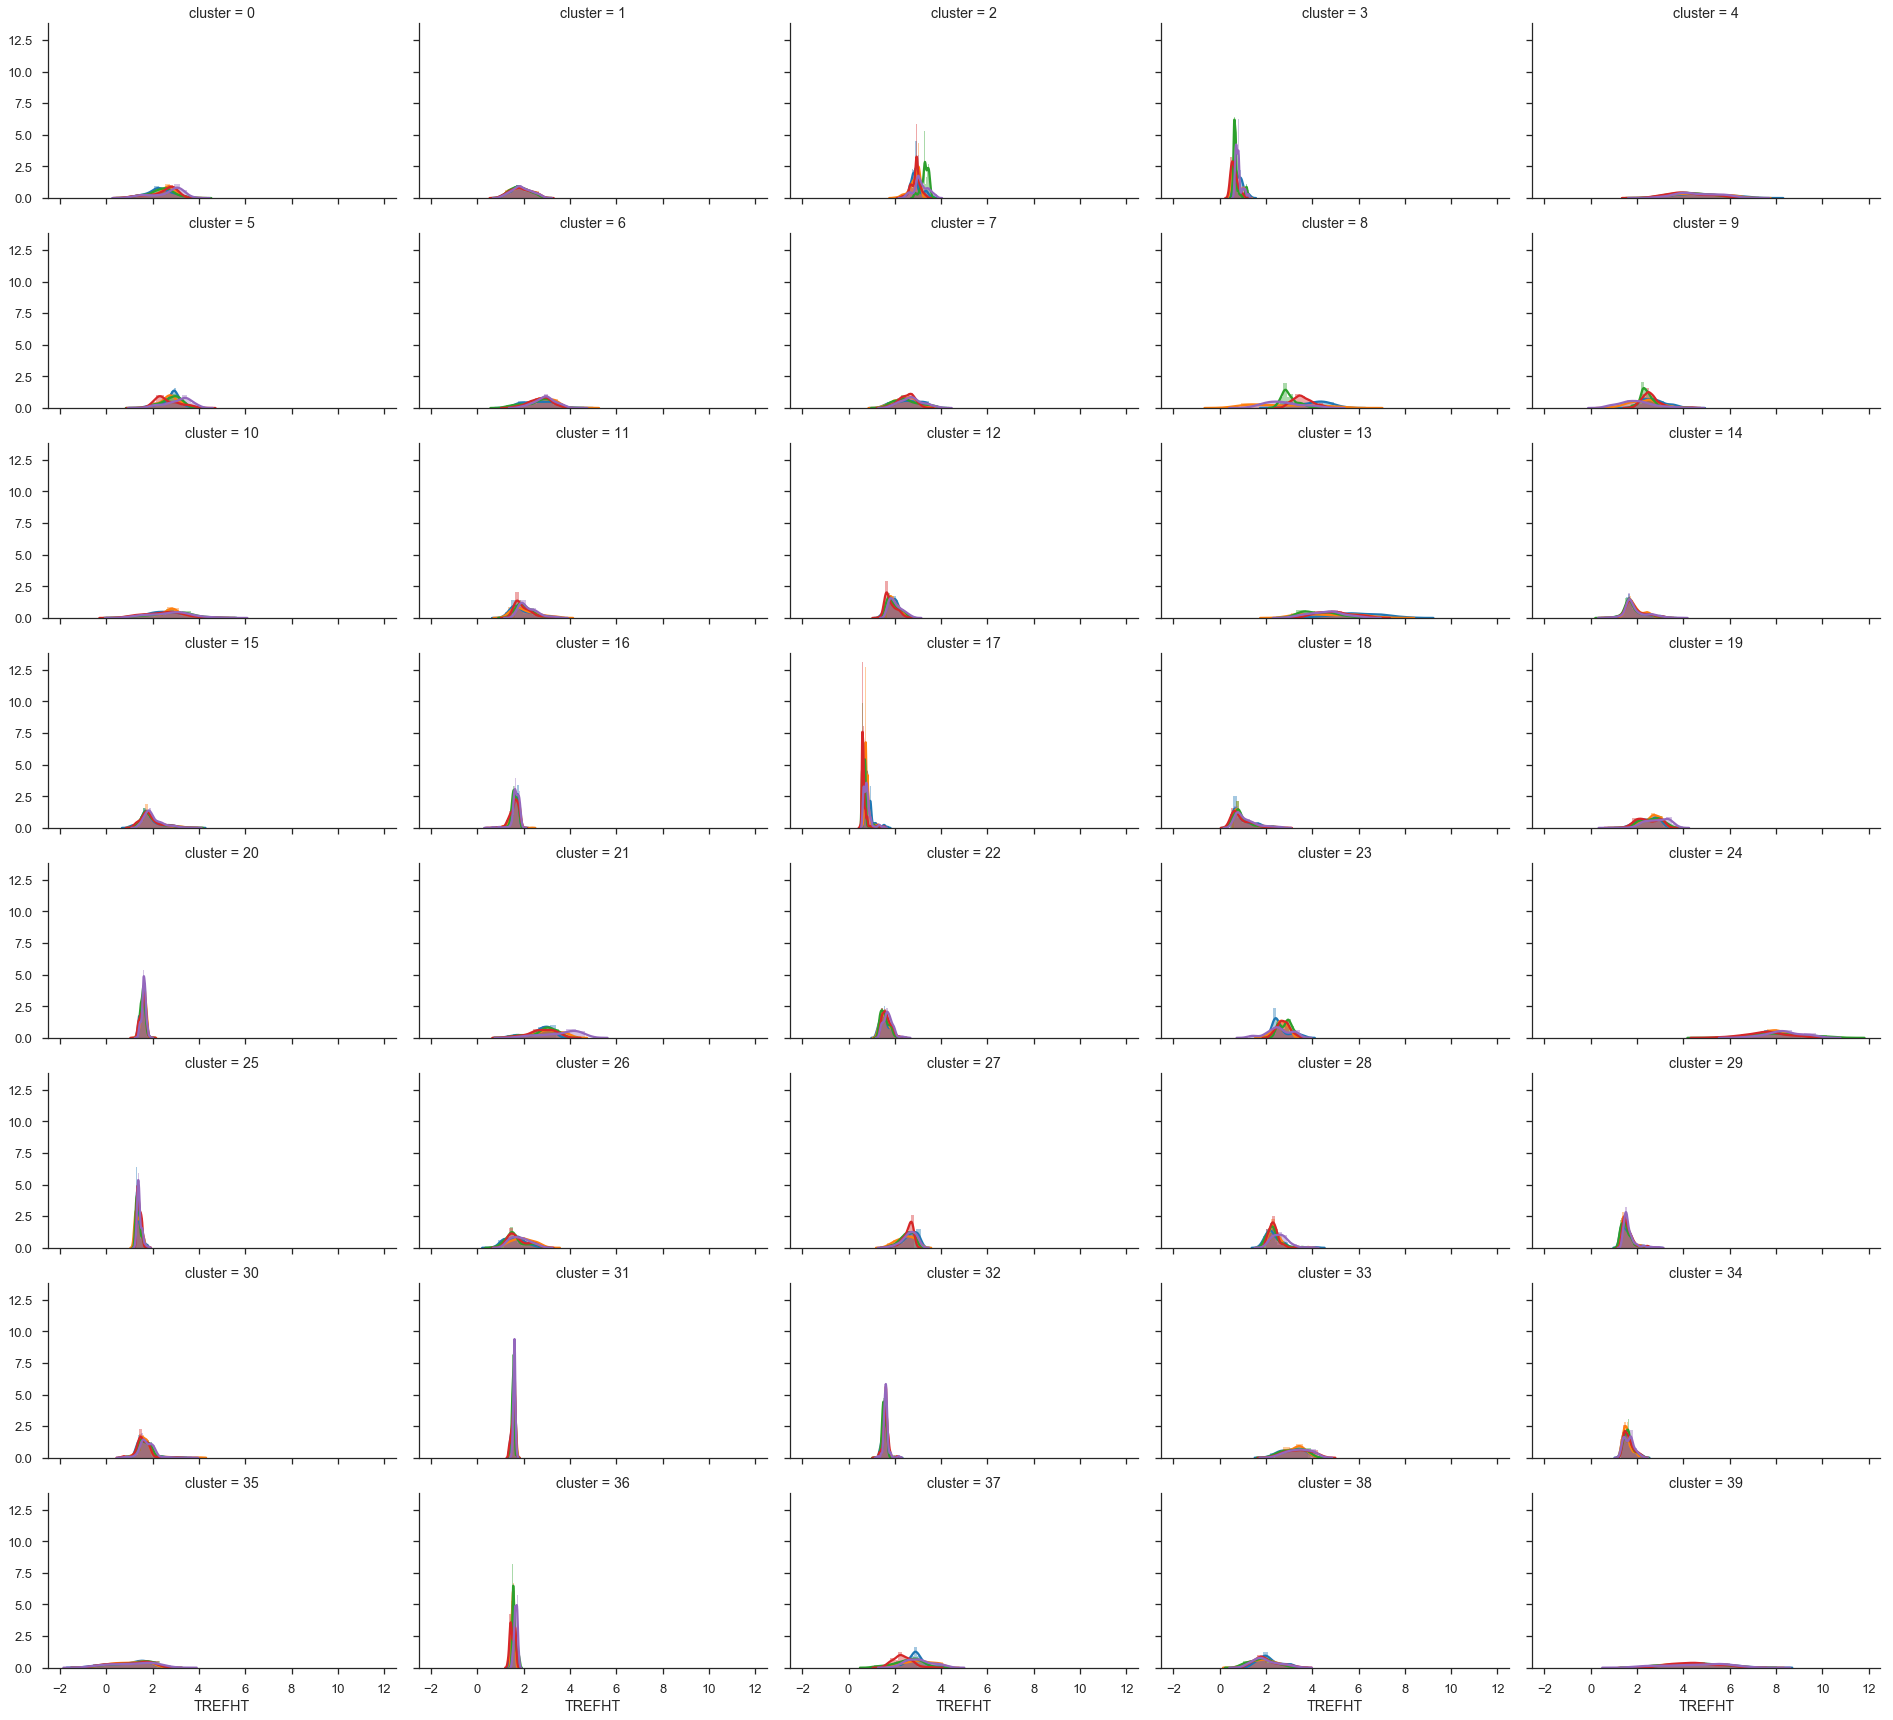

In [34]:
import seaborn as sns

g = sns.FacetGrid(
    df,      
    col='cluster', col_wrap=5, hue='ic', aspect=1.75
)
g.map(sns.distplot, 'TREFHT')

In [35]:
from ipywidgets import interactive

def geo_cluster_dist(cluster=0):
    plt.close("all")
    fig = plt.figure()
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
    dfc = df[df.cluster == cluster]
    dac = data.cluster.where(data.cluster == cluster)
    dac.plot.pcolormesh(ax=ax, infer_intervals=True, add_colorbar=False, transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.outline_patch.set_visible(False)
    
    ax2 = plt.axes([1., 0.15, 0.1, .7])
    for ic in range(5):
        dfc_ic = dfc[dfc.ic == ic+1]
        sns.distplot(dfc_ic.TREFHT, 
                     hist=False,
                     vertical=True, ax=ax2, )
    ax2.set_ylim(0, 4)
    ylo, yhi = ax2.get_ylim()
    if ylo < 0 < yhi:
        ax2.hlines(0, 0, 1, lw=0.2)
    sns.despine(ax=ax2, trim=True, bottom=True)
    plt.show()
    
interactive(geo_cluster_dist, cluster=(0, n_clusters))